## Intro to Domino Project

See the getting started [docs](https://docs.dominodatalab.com/en/4.1/get_started/index.html) to set up this project. This notebook outlines step 5, using Jupyter to load, explore, and transform some data. After the data has been prepared, we will train a model.

See [this document](https://www.bmreports.com/bmrs/?q=generation/fueltype/current) for information on the data and column headers.

##### quick validation that requirements for model deployment are met

In [1]:
! pip list | grep 'papermill\|pystan\|plotly\|dash\|fbprophet\|requests'

dash                               1.14.0
dash-core-components               1.10.2
dash-html-components               1.0.3
dash-renderer                      1.6.0
dash-table                         4.9.0
fbprophet                          0.6
papermill                          2.1.2
plotly                             4.9.0
pystan                             2.19.1.1
requests                           2.22.0


In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import datetime
import os

import requests
import subprocess

import pystan
from fbprophet import Prophet

import matplotlib.pyplot as plt
import numpy as np

import data_refresh

import pickle

import upload_to_S3

In [51]:
import json

In [4]:
#fix plt bug for timestamp indices
pd.plotting.register_matplotlib_converters()

## Load, Prep, Visualize

In [27]:
df =pd.read_csv('/mnt/data/training_data.csv', skiprows=1, skipfooter=1, header=None, engine='python')

In [28]:
# rename the columns
df.columns = ['HDF', 'date', 'half_hour_increment',
                  'CCGT', 'OIL', 'COAL', 'NUCLEAR',
                  'WIND', 'PS', 'NPSHYD', 'OCGT',
                  'OTHER', 'INTFR', 'INTIRL', 'INTNED',
                   'INTEW', 'BIOMASS', 'INTEM']

# Create a new column datetime that represents the starting datetime of the measured increment
df['datetime'] = pd.to_datetime(df['date'], format="%Y%m%d")
df['datetime'].describe()

count                    4320
unique                     90
top       2020-06-14 00:00:00
freq                       48
first     2020-05-13 00:00:00
last      2020-08-10 00:00:00
Name: datetime, dtype: object

In [29]:
df['datetime'] = df.apply(lambda x:x['datetime']+ datetime.timedelta(minutes=30*(int(x['half_hour_increment'])-1)), 
                          axis = 1)

In [30]:
df.head()

,HDF,date,half_hour_increment,CCGT,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,OCGT,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTEM,datetime
0,FUELHH,20200513,1,5974,0,0,5559,5044,8,171,1,115,1508,0,366,0,2260,756,2020-05-13 00:00:00
1,FUELHH,20200513,2,5465,0,0,5568,5224,0,168,0,111,1506,0,356,0,2259,756,2020-05-13 00:30:00
2,FUELHH,20200513,3,5408,0,0,5617,5424,0,147,0,110,1408,0,316,0,2251,708,2020-05-13 01:00:00
3,FUELHH,20200513,4,5333,0,0,5654,5460,0,147,0,113,1408,0,316,0,2246,708,2020-05-13 01:30:00
4,FUELHH,20200513,5,5320,0,0,5672,5532,0,147,0,109,1408,0,222,0,2242,706,2020-05-13 02:00:00


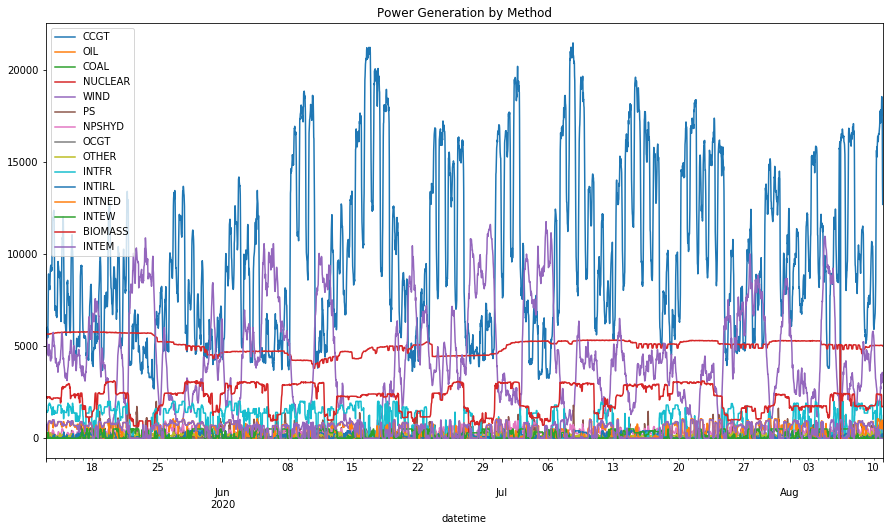

In [31]:
# Visualize the data to see how each fuel type is used during the day by plotting the data
df.drop(['HDF', 'date', 'half_hour_increment'], axis = 1).set_index('datetime').plot(figsize=(15,8))
plt.title('Power Generation by Method')
plt.savefig(os.environ['DOMINO_WORKING_DIR']+'/results/fuel_daily.png')
plt.show()

In [32]:
# drop unneeded features
df['y'] = df.drop(['date','HDF','half_hour_increment'],axis=1).sum(axis=1)

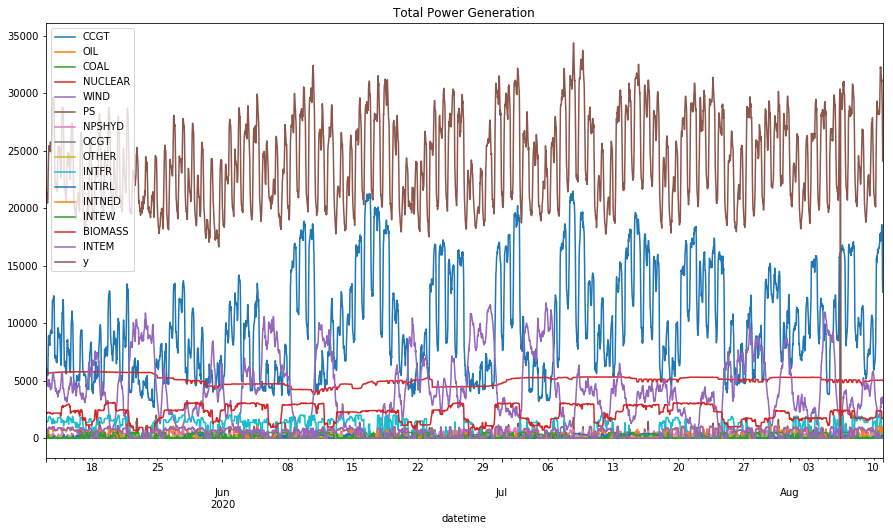

In [33]:
df.drop(['HDF', 'date', 'half_hour_increment'], axis = 1).set_index('datetime').plot(figsize=(15,8))
plt.title('Total Power Generation')
plt.savefig(os.environ['DOMINO_WORKING_DIR']+'/results/total_daily.png')
plt.show()

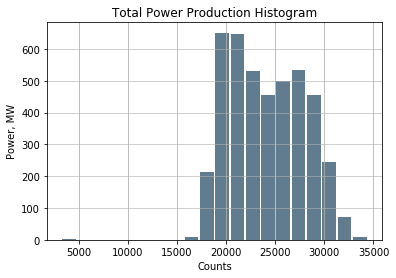

In [34]:
df['y'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Total Power Production Histogram')
plt.xlabel('Counts')
plt.ylabel('Power, MW')
plt.grid(axis='y', alpha=0.75)
plt.savefig(os.environ['DOMINO_WORKING_DIR']+'/results/total_hist.png')
plt.show()

In [35]:
# Prep our data - for Facebook Prophet, the time series data needs to be in a DataFrame with 2 columns named ds and y
df['timestamp'] = df.loc[:,'datetime']
column_list = ['timestamp','CCGT', 'OIL', 'COAL', 'NUCLEAR',
       'WIND', 'PS', 'NPSHYD', 'OCGT', 'OTHER', 'INTFR', 'INTIRL', 'INTNED',
       'INTEW', 'BIOMASS', 'INTEM', 'datetime', 'y']
df = df[column_list]

In [36]:
df = df.rename(columns = {'datetime':'ds'})
prepped = df[['ds', 'y']]

print('full df columns: '+str(df.columns))
print('prophet df columns: '+str(prepped.columns))

full df columns: Index(['timestamp', 'CCGT', 'OIL', 'COAL', 'NUCLEAR', 'WIND', 'PS', 'NPSHYD',
       'OCGT', 'OTHER', 'INTFR', 'INTIRL', 'INTNED', 'INTEW', 'BIOMASS',
       'INTEM', 'ds', 'y'],
      dtype='object')
prophet df columns: Index(['ds', 'y'], dtype='object')


### Train our model
The CCGT column representing “combined-cycle gas turbines” seems to be the most interesting. It generates a lot of energy and is very volatile.

We will concentrate on this column and try to predict the power generation from this fuel source.

In [37]:
cap = prepped['y'].max()
cap

34384

In [40]:
#floor = prepped['y'].min()
floor = 15000
floor

15000

In [41]:
train_prop = 0.9
print(train_prop)
# Split the dataset into train and test sets
X = prepped.copy()
y = prepped['y']

0.9


In [42]:
X['cap'] = cap
X['floor'] = floor

In [43]:
split_index = int(train_prop*len(y))
print("split index is {}".format(split_index))

train = X.iloc[:split_index]
test, labels = X.iloc[split_index:], y.iloc[split_index:]

split index is 3888


In [44]:
df['ds'][3888]

Timestamp('2020-08-02 00:00:00')

In [45]:
df['ds'][-1:]

4319   2020-08-10 23:30:00
Name: ds, dtype: datetime64[ns]

In [46]:
train.head()

,ds,y,cap,floor
0,2020-05-13 00:00:00,21762,34384,15000
1,2020-05-13 00:30:00,21413,34384,15000
2,2020-05-13 01:00:00,21389,34384,15000
3,2020-05-13 01:30:00,21385,34384,15000
4,2020-05-13 02:00:00,21358,34384,15000


In [47]:
print("training model using Prophet..")
m = Prophet(yearly_seasonality=False, growth='logistic')
m.fit(train)

## Trained models are meant to be used. There is no reason to re-train the model each time you use the model. 
#Export or serialize the model to a file to load and reuse the model later. In Python, the pickle module implements protocols for serializing and de-serializing objects.
m.stan_backend.logger = None    #uncomment if using Python 3.6 and fbprophet==0.6
with open("/mnt/trained_models/model.pkl", "wb") as f:
    pickle.dump(m, f)

training model using Prophet..


In [48]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(m, initial='72 days', period='8 hours', horizon = '1 days')
df_cv.head()

INFO:fbprophet:Making 24 forecasts with cutoffs between 2020-07-24 07:30:00 and 2020-07-31 23:30:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-24 08:00:00,26284.623235,24072.447912,28210.377745,26895,2020-07-24 07:30:00
1,2020-07-24 08:30:00,26796.991260,24553.249081,29090.594256,27998,2020-07-24 07:30:00
2,2020-07-24 09:00:00,27162.905481,25002.490348,29395.424308,28299,2020-07-24 07:30:00
3,2020-07-24 09:30:00,27372.360078,25227.275671,29373.203196,28072,2020-07-24 07:30:00
4,2020-07-24 10:00:00,27432.750702,25280.265760,29591.489594,28078,2020-07-24 07:30:00


In [49]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.shape

(44, 7)

In [50]:
df_p.describe()

,horizon,mse,rmse,mae,mape,mdape,coverage
count,44,4.400000e+01,44.000000,44.000000,44.000000,44.000000,44.000000
mean,0 days 13:15:00,6.686113e+06,2582.413576,1744.277987,0.074261,0.052623,0.757172
std,0 days 06:25:21.418641,7.015582e+05,132.869468,88.872117,0.004368,0.008612,0.043210
min,0 days 02:30:00,5.802716e+06,2408.882762,1590.716725,0.067684,0.038410,0.666667
25%,0 days 07:52:30,6.201095e+06,2490.197688,1682.186614,0.070569,0.047517,0.719928
50%,0 days 13:15:00,6.522629e+06,2553.941936,1718.494118,0.073400,0.051026,0.767391
75%,0 days 18:37:30,7.086695e+06,2662.084174,1808.870509,0.076561,0.058804,0.790308
max,1 days 00:00:00,8.370400e+06,2893.164389,1942.079897,0.084396,0.071496,0.817754


In [52]:
results_dict = {}

In [53]:
results_dict['avg_rmse'] = df_p['rmse'].mean()
results_dict['avg_mape'] = df_p['mape'].mean()
results_dict['coverage'] = df_p['coverage'].mean()

In [54]:
with open('dominostats.json', 'w') as f:
    f.write(json.dumps(results_dict))

In [55]:
#Make a DataFrame to hold the predictions and predict future values of total power generation

#future = m.make_future_dataframe(periods=int(len(labels)), freq='30min')
forecast = m.predict(test)

#inspect the dataframe
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
427,2020-08-10 21:30:00,27103.947605,24776.821657,29041.770446
428,2020-08-10 22:00:00,26255.086486,24030.931472,28436.283820
429,2020-08-10 22:30:00,25362.484497,23195.573997,27574.167975
430,2020-08-10 23:00:00,24486.313066,22290.958435,26648.301006
431,2020-08-10 23:30:00,23674.689040,21466.864424,25885.675604


<Figure size 432x288 with 0 Axes>

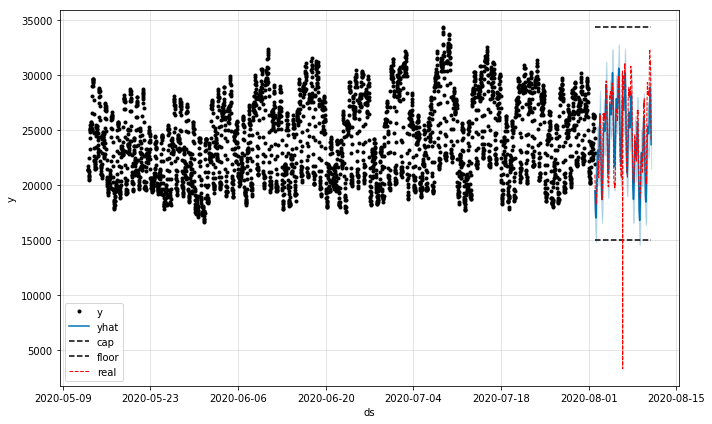

In [56]:
plt.gcf()
fig = m.plot(forecast)
plt.plot(test['ds'].dt.to_pydatetime(), test['y'], 'r', linewidth = 1, linestyle = '--', label = 'real')
plt.legend()
plt.savefig(os.environ['DOMINO_WORKING_DIR']+'/results/power_forecast.png')

### Dev: Export train, test+predictions, and ground truth labels for DMM example
Trained models are meant to be used. There is no reason to re-train the model each time you use the model. Export or serialize the model to a file to load and reuse the model later. In Python, the pickle module implements protocols for serializing and de-serializing objects.

In [58]:
def split_data_export(df,n,prefix):

    print("exporting {} data..".format(prefix))
    arrays = np.array_split(df,n)
    df_dict = {}
    file_names = list()

    for i in range(n):
        df_dict["partition{0}".format(i+1)] = arrays[i]

    for key, value in df_dict.items():
        if n ==1:
            name = os.environ['DOMINO_WORKING_DIR']+'/results/{0}.csv'.format(prefix)
        else:
            name = os.environ['DOMINO_WORKING_DIR']+'/results/{0}_{1}.csv'.format(prefix,key)

        file_names.append(name)   
        value.to_csv(name)
    print(file_names)
    return file_names

In [59]:
df.columns

Index(['timestamp', 'CCGT', 'OIL', 'COAL', 'NUCLEAR', 'WIND', 'PS', 'NPSHYD',
       'OCGT', 'OTHER', 'INTFR', 'INTIRL', 'INTNED', 'INTEW', 'BIOMASS',
       'INTEM', 'ds', 'y'],
      dtype='object')

In [60]:
## EXPORT RESULTS (for DMM) ##
logged_tr_data = df.iloc[:split_index].set_index('ds')

In [61]:
logged_tr_data.columns

Index(['timestamp', 'CCGT', 'OIL', 'COAL', 'NUCLEAR', 'WIND', 'PS', 'NPSHYD',
       'OCGT', 'OTHER', 'INTFR', 'INTIRL', 'INTNED', 'INTEW', 'BIOMASS',
       'INTEM', 'y'],
      dtype='object')

In [62]:
training = split_data_export(logged_tr_data,1,'training')

exporting training data..
['/mnt/results/training.csv']


In [63]:
# preds - add input data back into prediction dataset
pred_data = df.iloc[split_index:].drop(columns=['y']).set_index('ds')
preds = forecast[['yhat','ds']].set_index('ds').rename(columns = {'yhat':'y'})
preds = pd.merge(pred_data, preds, how='inner', on='ds')

In [64]:
preds.columns

Index(['timestamp', 'CCGT', 'OIL', 'COAL', 'NUCLEAR', 'WIND', 'PS', 'NPSHYD',
       'OCGT', 'OTHER', 'INTFR', 'INTIRL', 'INTNED', 'INTEW', 'BIOMASS',
       'INTEM', 'y'],
      dtype='object')

In [65]:
len(logged_tr_data.columns) == len(preds.columns)

True

In [66]:
validation = split_data_export(preds,2,'predictions')

exporting predictions data..
['/mnt/results/predictions_partition1.csv', '/mnt/results/predictions_partition2.csv']


In [67]:
# ground truth
gt = pd.concat([labels, test[['ds']]], axis=1, sort=False).rename(columns = {'y':'y_gt'}).reset_index(drop=True).set_index('ds')
val_labels = split_data_export(gt,2,'ground_truth')

exporting ground_truth data..
['/mnt/results/ground_truth_partition1.csv', '/mnt/results/ground_truth_partition2.csv']


In [68]:
file_name_dict = {}

In [69]:
file_name_dict['train'] = training
file_name_dict['predictions'] = validation
file_name_dict['ground_truth'] = val_labels

In [70]:
json = json.dumps(file_name_dict)
f = open("/mnt/temp/output_files.json","w")
f.write(json)
f.close()